In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import pandas as pd
import numpy as np
# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.cbook import boxplot_stats
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform, expon, loguniform
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score,mean_absolute_percentage_error
from sklearn import metrics
from sklearn.preprocessing import PowerTransformer


from sklearn.base import BaseEstimator, TransformerMixin

sns.set_theme(style="whitegrid")

In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Deve ser alterado para onde está o diretório da base
PATH_BASE_FINAL = '/content/drive/MyDrive/Estudos/Mestrado-ppgia/IA_Generativa/2°VA/Base_final.csv'


In [ ]:
# pré-processamento de um conjunto de dados; seleção de colunas, padronização de valores, filtragem de instituições e
# transformação dos dados numéricos e categóricos. Normalização de variáveis numéricas para gerar um Dataframe unico.
class PreProcessingCensoSuperior():

  def __init__(self):

    df = pd.read_csv(PATH_BASE_FINAL, sep=';')

    self.dataset = df[['NU_ANO_CENSO', 'CO_REGIAO', 'IN_CAPITAL',
       'QT_TEC_TOTAL', 'IN_ACESSO_PORTAL_CAPES',
       'IN_REPOSITORIO_INSTITUCIONAL', 'IN_BUSCA_INTEGRADA',
       'IN_SERVICO_INTERNET', 'IN_PARTICIPA_REDE_SOCIAL', 'IN_CATALOGO_ONLINE',
       'IN_OUTRAS_BASES', 'QT_PERIODICO_ELETRONICO', 'QT_LIVRO_ELETRONICO',
        'T1_TP_REFERENTE',  'T2_NOME_CATEGORIA_ADMINISTRATIVA',
       'NOME_ORGANIZACAO_ACADEMICA', 'QT_ALUNOS', 'QT_DOCENTES', 'QT_CURSO', 'T1_VL_RECEITAS', 'T1_VL_DESPESAS']]

    # Padronizar variável tp_referente
    self.dataset.loc[self.dataset["T1_TP_REFERENTE"] == 1,'T1_TP_REFERENTE'] = 1
    self.dataset.loc[self.dataset["T1_TP_REFERENTE"] == 2,'T1_TP_REFERENTE'] = 0

    # Apenas instituições mantidas por ela mesma
    self.dataset = self.dataset[self.dataset["T1_TP_REFERENTE"] == 0]
    self.dataset = self.dataset.drop(columns=["T1_TP_REFERENTE"])

    self.dataset_ref = self.dataset.copy()

    self.colunas_numericas = ['QT_ALUNOS', 'QT_DOCENTES', 'QT_CURSO', 'QT_TEC_TOTAL', 'QT_PERIODICO_ELETRONICO', 'QT_LIVRO_ELETRONICO', 'T1_VL_RECEITAS', 'T1_VL_DESPESAS']
    self.categoric_columns = self.dataset.drop(columns=self.colunas_numericas).columns
    self.sample_numericas = self.dataset[self.colunas_numericas]

    self.applyOHE()
    self.applyPowerTransformation()
    self.joinCategoriesWithNumerics()

  def applyOHE(self):
    columnsohe = []
    for col in self.categoric_columns:
      if col not in ['IN_CAPITAL',
          'IN_OUTRAS_BASES', 'IN_REPOSITORIO_INSTITUCIONAL',
          'IN_BUSCA_INTEGRADA', 'IN_SERVICO_INTERNET', 'IN_PARTICIPA_REDE_SOCIAL',
          'IN_CATALOGO_ONLINE','TP_REFERENTE','T1_TP_REFERENTE','IN_ACESSO_PORTAL_CAPES']:
        oh = preprocessing.OneHotEncoder()
        values = oh.fit_transform(self.dataset[[col]])
        self.dataset = self.dataset.drop(columns = [col])
        new_columns = []
        for new_cols in oh.categories_[0]:
          new_columns.append(f"{col}.{new_cols}")
          columnsohe.append(f"{col}.{new_cols}")
        self.dataset.loc[:,new_columns] = values.toarray()
    self.categoric_columns = ['IN_CAPITAL',
       'IN_OUTRAS_BASES', 'IN_REPOSITORIO_INSTITUCIONAL',
       'IN_BUSCA_INTEGRADA', 'IN_SERVICO_INTERNET', 'IN_PARTICIPA_REDE_SOCIAL',
       'IN_CATALOGO_ONLINE','IN_ACESSO_PORTAL_CAPES'] + columnsohe

  def applyPowerTransformation(self):
    # Tranformação PowerTranformer no valores numericos
    self.sample_numericas = pd.DataFrame(PowerTransformer(method="yeo-johnson").fit_transform(self.sample_numericas),columns=self.sample_numericas.columns)

  def joinCategoriesWithNumerics(self):
    self.dataset = pd.concat([self.sample_numericas,self.dataset[self.categoric_columns].reset_index().iloc[:,1:]],axis = 1)

  def set_dataset(self,dataset):
    self.dataset = dataset


In [ ]:
censoDataset = PreProcessingCensoSuperior()

In [ ]:
censoDataset.dataset.columns.tolist()

['QT_ALUNOS',
 'QT_DOCENTES',
 'QT_CURSO',
 'QT_TEC_TOTAL',
 'QT_PERIODICO_ELETRONICO',
 'QT_LIVRO_ELETRONICO',
 'T1_VL_RECEITAS',
 'T1_VL_DESPESAS',
 'IN_CAPITAL',
 'IN_OUTRAS_BASES',
 'IN_REPOSITORIO_INSTITUCIONAL',
 'IN_BUSCA_INTEGRADA',
 'IN_SERVICO_INTERNET',
 'IN_PARTICIPA_REDE_SOCIAL',
 'IN_CATALOGO_ONLINE',
 'IN_ACESSO_PORTAL_CAPES',
 'NU_ANO_CENSO.2016',
 'NU_ANO_CENSO.2017',
 'NU_ANO_CENSO.2018',
 'NU_ANO_CENSO.2019',
 'CO_REGIAO.1',
 'CO_REGIAO.2',
 'CO_REGIAO.3',
 'CO_REGIAO.4',
 'CO_REGIAO.5',
 'T2_NOME_CATEGORIA_ADMINISTRATIVA.Privada com fins lucrativos',
 'T2_NOME_CATEGORIA_ADMINISTRATIVA.Privada sem fins lucrativos',
 'T2_NOME_CATEGORIA_ADMINISTRATIVA.Pública Estadual',
 'T2_NOME_CATEGORIA_ADMINISTRATIVA.Pública Federal',
 'T2_NOME_CATEGORIA_ADMINISTRATIVA.Pública Municipal e Especial',
 'NOME_ORGANIZACAO_ACADEMICA.Centro Federal de Educação Tecnológica',
 'NOME_ORGANIZACAO_ACADEMICA.Centro Universitário',
 'NOME_ORGANIZACAO_ACADEMICA.Faculdade',
 'NOME_ORGANIZACAO_ACA

In [ ]:
numpy_censo = censoDataset.dataset.to_numpy()

## K-means

### Método cotovelo

Text(0.5, 1.0, 'Densiidade cluster silhueta')

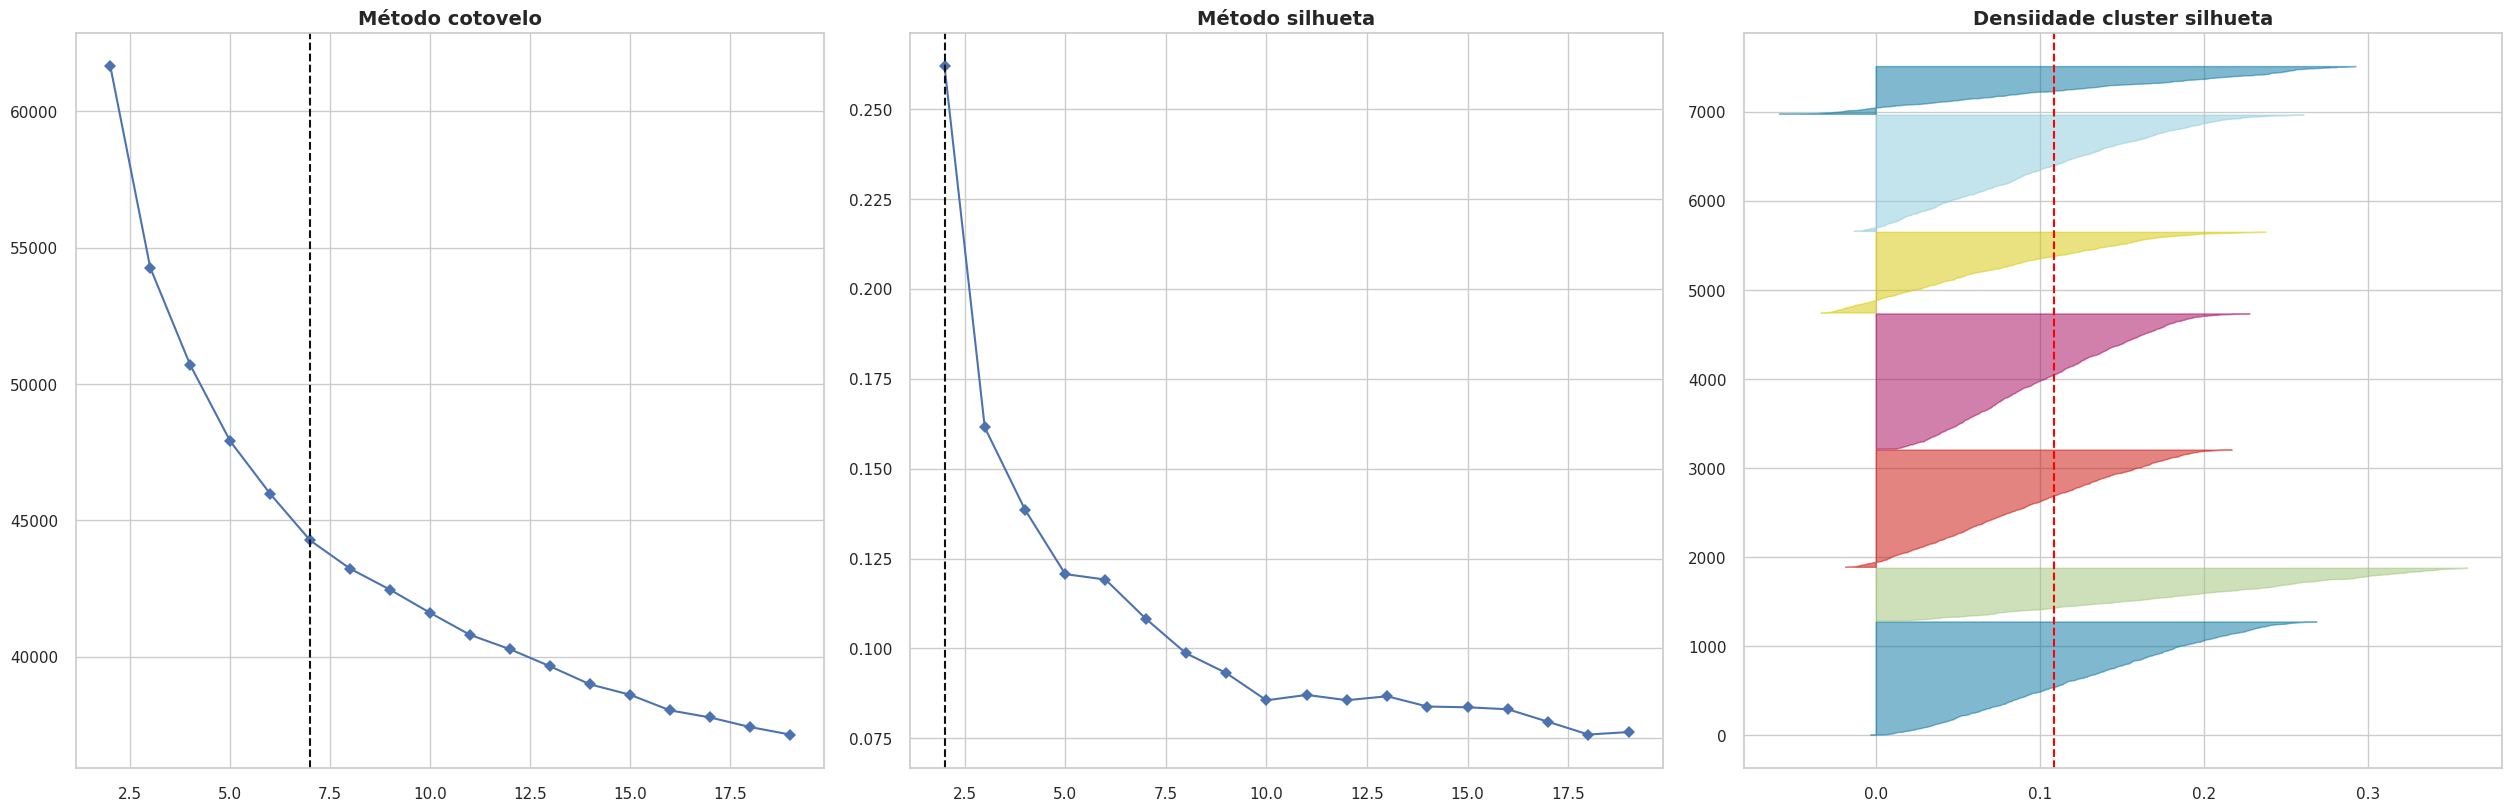

In [ ]:
# Análise de agrupamento (clustering) com o algoritmo K-Means. A visualização acontece com o
# métodos do cotovelo para determinar o número ideal de clusters com base na variação intra-cluster;
# a métrica de silhueta para avaliar a coesão e separação dos clusters;
# e a densidade da silhueta para visualizar a qualidade dos agrupamentos com um número específico de clusters (7).

from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(random_state=0,algorithm='lloyd')

fig = plt.figure(constrained_layout=True,figsize=(25,8))
fig.patch.set_facecolor('white')

def plot_elbow(model,data,ax):
  visualizer = KElbowVisualizer(model, k=(2,20), timings=False,ax=ax)
  visualizer.fit(data)

def plot_silhouette_k(model,data,ax):
  visualizer = KElbowVisualizer(model, k=(2,20), timings=False,ax=ax,metric='silhouette')
  visualizer.fit(data)

def plot_shilhoutte(model,data,ax,k):
  visualizer = SilhouetteVisualizer(KMeans(k), colors='yellowbrick',ax=ax)
  visualizer.fit(data)

subfigs = fig.subfigures(nrows=1, ncols=3)

ax = subfigs[0].subplots(nrows=1, ncols=1)

plot_elbow(model, numpy_censo, ax)

ax.set_title("Método cotovelo",fontsize=14,fontweight="bold")

ax2 = subfigs[1].subplots(nrows=1, ncols=1)
plot_silhouette_k(model, numpy_censo, ax2)

ax2.set_title("Método silhueta",fontsize=14,fontweight="bold")

ax3 = subfigs[2].subplots(nrows=1, ncols=1)
plot_shilhoutte(model, numpy_censo, ax3, 7)
ax3.set_title("Densiidade cluster silhueta",fontsize=14,fontweight="bold")


### Modelo

In [ ]:
#Aplica o Kmeans nos clusters
kmeans_model = KMeans( n_clusters = 7, random_state = 0)
kmeans_model.fit_predict(numpy_censo)

array([0, 0, 0, ..., 1, 2, 3], dtype=int32)

In [ ]:
# Renomeando os clusters
segments_names = {0:'Primeiro', 1:'Segundo', 2:'Terceiro',3:'Quarto',
                    4:'Quinto',5:'Sexto',6:"Sétimo",7:'Oitavo',8:"Nono",9:"Décimo"}
censoDataset.dataset_ref['K-means Clusters'] = list(map(lambda i: segments_names[i],kmeans_model.labels_))

## Aglomerativo

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

In [ ]:
# Armazena matrizes geradas a partir dos métodos de agrupamento
linkage = {
    'ward': linkage(numpy_censo, method = 'ward'),
    'single': linkage(numpy_censo, method = 'single'),
    'complete': linkage(numpy_censo, method = 'complete'),
    'average': linkage(numpy_censo, method = 'average'),
}

### Dendograma

In [ ]:
import sys
sys.setrecursionlimit(30000)

Text(0.5, 1.0, 'Average Dendrograma')

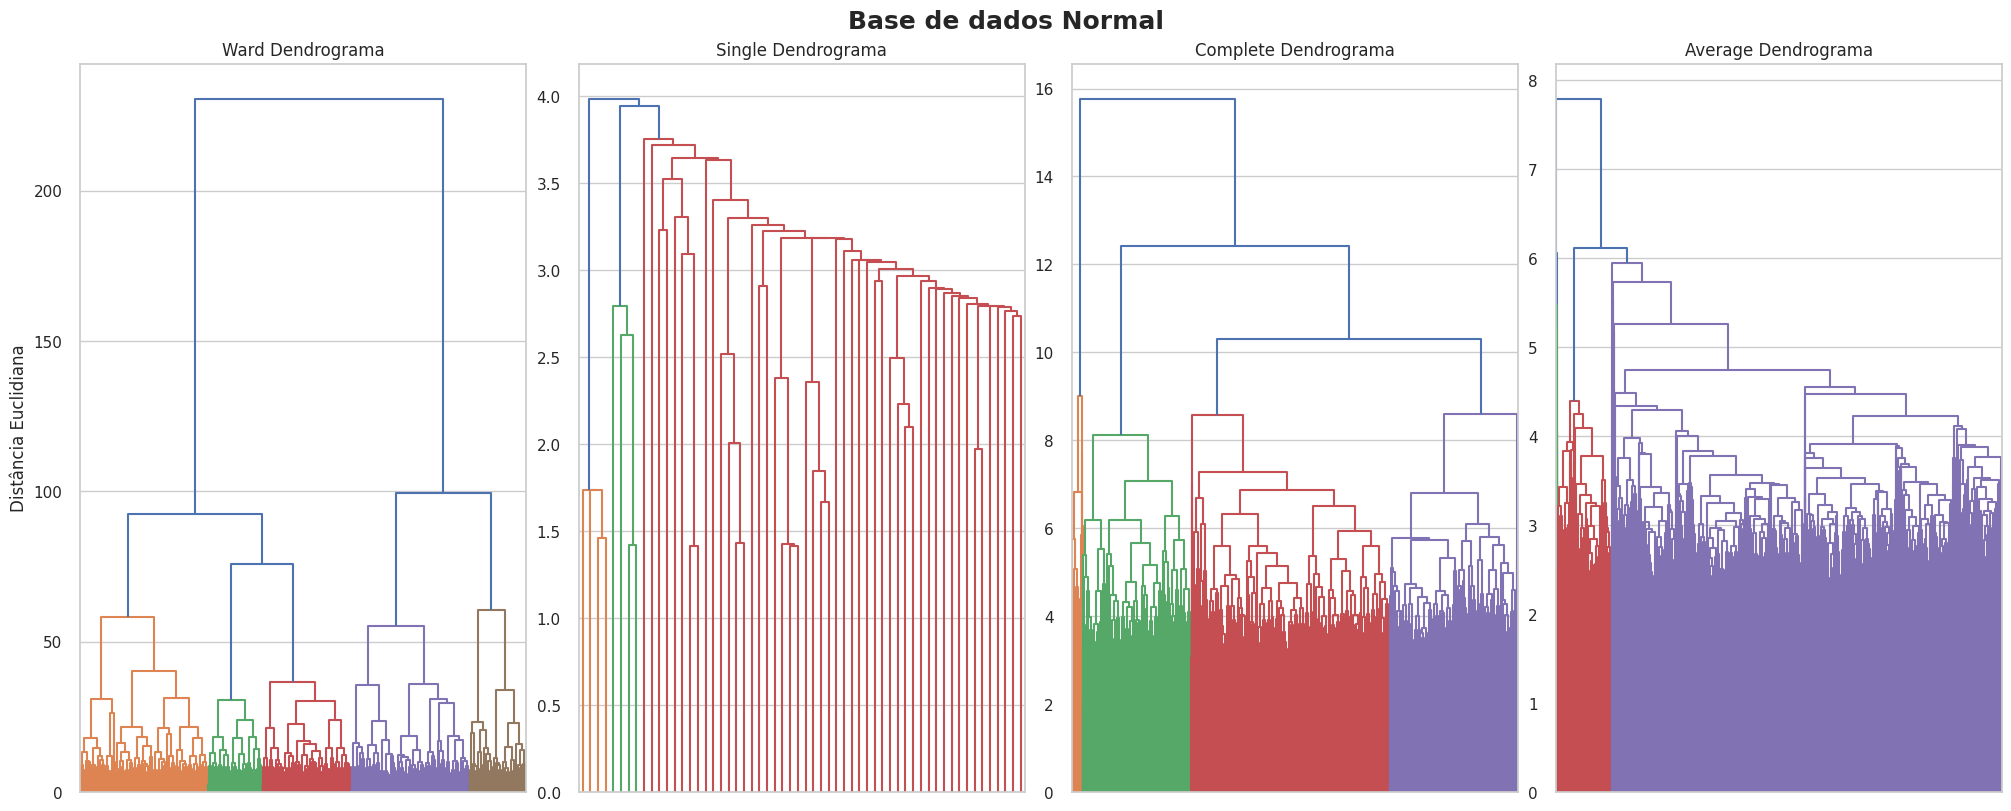

In [ ]:
# Análise dos clusters por meio de dendrogramas, utilizando os métodos hierárquicos Ward, Single, Complete e Average.
fig = plt.figure(constrained_layout=True,figsize=(20,8))
fig.patch.set_facecolor('white')
fig.suptitle(f'Base de dados Normal',fontsize=18,fontweight="bold")

subfigs = fig.subfigures(nrows=1, ncols=1)

axs = subfigs.subplots(nrows=1, ncols=4)
dendrogram(linkage["ward"],ax=axs[0],truncate_mode="level", color_threshold=linkage["ward"][:,2][-4])
axs[0].set_xticks([])
axs[0].set_ylabel('Distância Euclidiana')
axs[0].set_title('Ward Dendrograma')
dendrogram(linkage["single"],ax=axs[1],truncate_mode="level", color_threshold=linkage["single"][:,2][-2])
axs[1].set_xticks([])
axs[1].set_title('Single Dendrograma')
dendrogram(linkage["complete"],ax=axs[2],truncate_mode="level", color_threshold=linkage["complete"][:,2][-3])
axs[2].set_xticks([])
axs[2].set_title('Complete Dendrograma')
dendrogram(linkage["average"],ax=axs[3],truncate_mode="level", color_threshold=linkage["average"][:,2][-3])
axs[3].set_xticks([])
axs[3].set_title('Average Dendrograma')



### modelo


In [ ]:
# Cluster aglomerativo, agrupando em 5 clusters com base na métrica de distância euclidiana e no método de linkage ward
agg_predictions = AgglomerativeClustering(n_clusters = 5,
                          metric = 'euclidean',
                          linkage = 'ward').fit_predict(numpy_censo)

In [ ]:
# renomeia e cria uma coluna Agglomerative Clusters em censoDataset.dataset_ref
segments_names = {0:'Primeiro', 1:'Segundo', 2:'Terceiro',3:'Quarto',
                    4:'Quinto',5:'Sexto',6:"Sétimo",7:'Oitavo',8:"Nono",9:"Décimo"}
censoDataset.dataset_ref['Agglomerative Clusters'] = list(map(lambda i: segments_names[i], agg_predictions))

# Visualização do dataset final

In [ ]:
censoDataset.dataset_ref.columns

Index(['NU_ANO_CENSO', 'CO_REGIAO', 'IN_CAPITAL', 'QT_TEC_TOTAL',
       'IN_ACESSO_PORTAL_CAPES', 'IN_REPOSITORIO_INSTITUCIONAL',
       'IN_BUSCA_INTEGRADA', 'IN_SERVICO_INTERNET', 'IN_PARTICIPA_REDE_SOCIAL',
       'IN_CATALOGO_ONLINE', 'IN_OUTRAS_BASES', 'QT_PERIODICO_ELETRONICO',
       'QT_LIVRO_ELETRONICO', 'T2_NOME_CATEGORIA_ADMINISTRATIVA',
       'NOME_ORGANIZACAO_ACADEMICA', 'QT_ALUNOS', 'QT_DOCENTES', 'QT_CURSO',
       'T1_VL_RECEITAS', 'T1_VL_DESPESAS', 'K-means Clusters',
       'Agglomerative Clusters'],
      dtype='object')

In [ ]:
# Cria o Dataset final e também ajusta o nome das Regiões
dataset_final = censoDataset.dataset_ref.copy()
dataset_final = dataset_final.rename(columns={'T2_NOME_CATEGORIA_ADMINISTRATIVA': 'NOME_CATEGORIA_ADMINISTRATIVA', 'CO_REGIAO': 'REGIAO'})

def map_region(item):
  if item['REGIAO'] == 1:
    return 'Norte'
  elif item['REGIAO'] == 2:
    return 'Nordeste'
  elif item['REGIAO'] == 3:
    return 'Sudeste'
  elif item['REGIAO'] == 4:
    return 'Sul'
  elif item['REGIAO'] == 5:
    return 'Centro-Oeste'

dataset_final['REGIAO'] = dataset_final.apply(lambda item: map_region(item), axis = 1)


In [ ]:
dataset_final.columns

Index(['NU_ANO_CENSO', 'REGIAO', 'IN_CAPITAL', 'QT_TEC_TOTAL',
       'IN_ACESSO_PORTAL_CAPES', 'IN_REPOSITORIO_INSTITUCIONAL',
       'IN_BUSCA_INTEGRADA', 'IN_SERVICO_INTERNET', 'IN_PARTICIPA_REDE_SOCIAL',
       'IN_CATALOGO_ONLINE', 'IN_OUTRAS_BASES', 'QT_PERIODICO_ELETRONICO',
       'QT_LIVRO_ELETRONICO', 'NOME_CATEGORIA_ADMINISTRATIVA',
       'NOME_ORGANIZACAO_ACADEMICA', 'QT_ALUNOS', 'QT_DOCENTES', 'QT_CURSO',
       'T1_VL_RECEITAS', 'T1_VL_DESPESAS', 'K-means Clusters',
       'Agglomerative Clusters'],
      dtype='object')

In [ ]:
#exporta os dados agrupados por clusters, gerando arquivos CSV separados para cada grupo
for cluster_name in dataset_final['K-means Clusters'].drop_duplicates().values.tolist():
  dataset_final[dataset_final['K-means Clusters'] == cluster_name].drop(columns=['K-means Clusters', 'Agglomerative Clusters']).to_csv(f'{cluster_name} agrupamento (K-means).csv', sep=";", index=False)

for cluster_name in dataset_final['Agglomerative Clusters'].drop_duplicates().values.tolist():
  dataset_final[dataset_final['Agglomerative Clusters'] == cluster_name].drop(columns=['K-means Clusters', 'Agglomerative Clusters']).to_csv(f'{cluster_name} agrupamento (Agglomerative).csv', sep=";", index=False)

In [ ]:
dataset_final.to_csv(f'Base final.csv', sep=";", index=False)

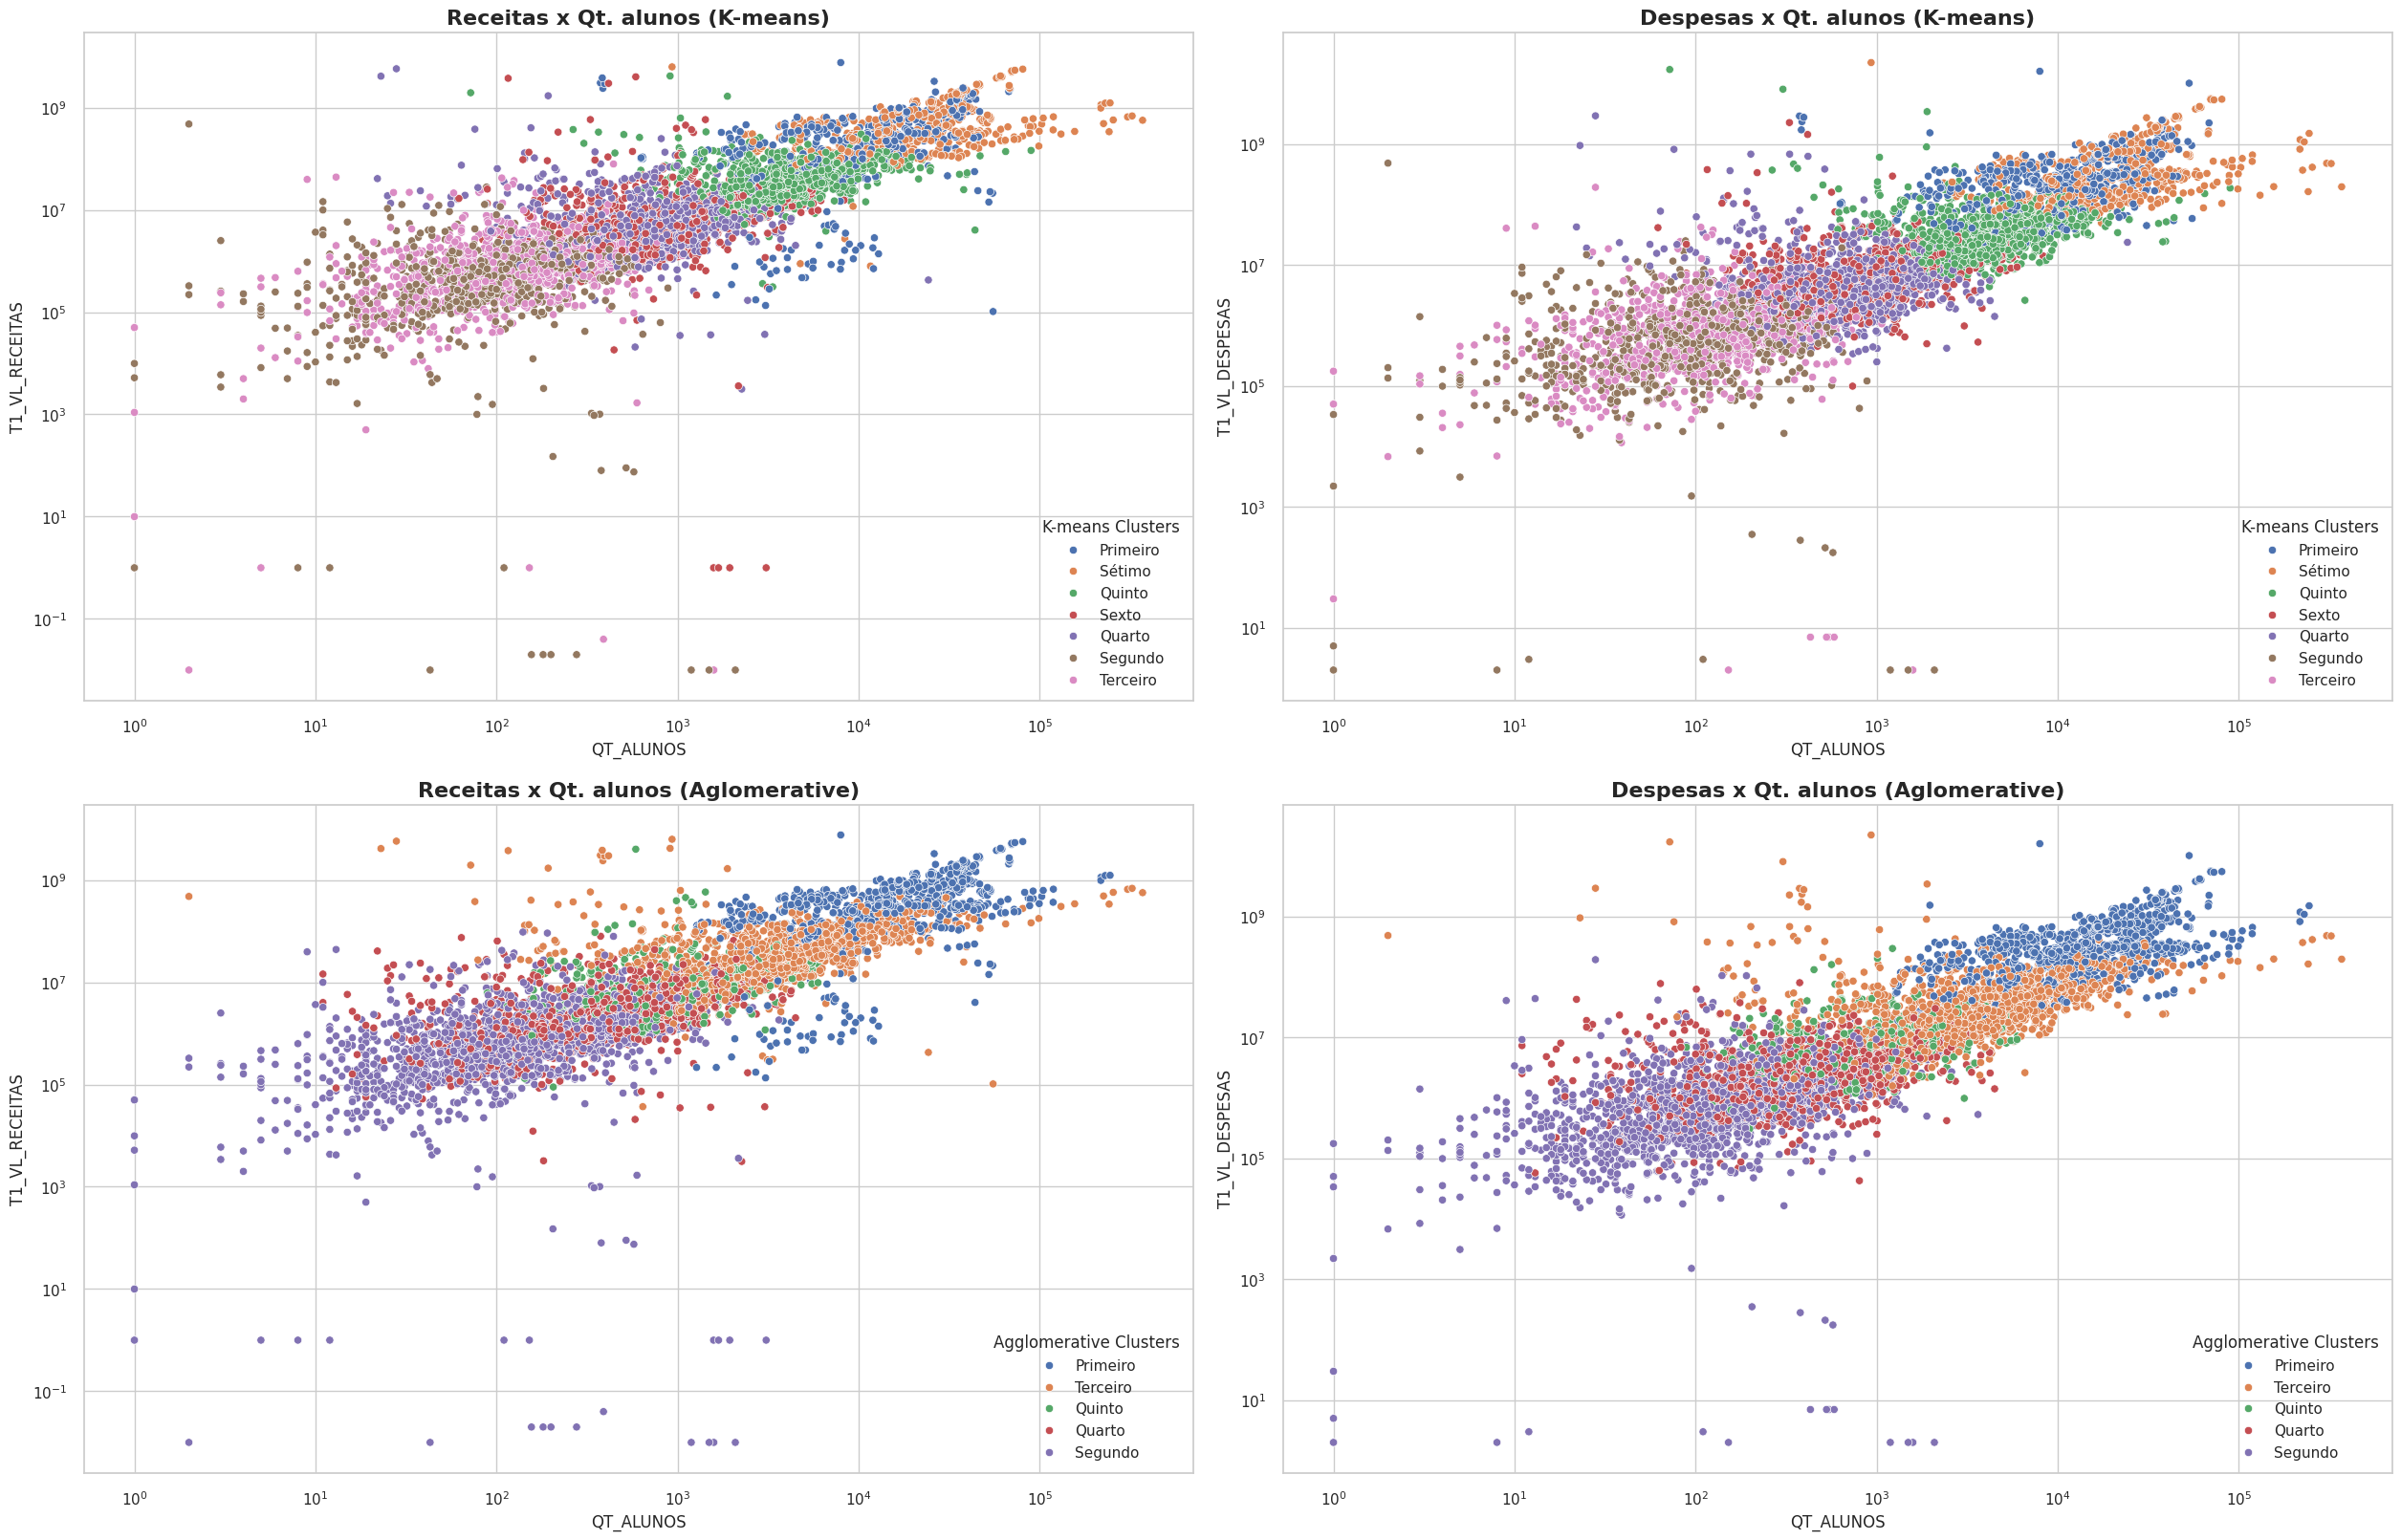

In [ ]:
# Compara variáveis financeiras e educacionais (T1_VL_RECEITAS, T1_VL_DESPESAS, QT_ALUNOS) para clusters gerados pelos métodos K-Means e Agglomerative, apresnetando a relação entre variaveis.
fig = plt.figure(constrained_layout=True,figsize=(25, 16))
fig.patch.set_facecolor('white')

title_config = {
  "fontweight": "bold",
  'fontsize':16
}

def plot_scatter_cluster(col1, col2, hue, ax, title):
  sns.scatterplot(
    data = dataset_final,
    y=col1,
    x=col2,
    hue=hue,
    ax=ax
  )

  ax.set_title(
    title,
    fontdict = title_config
  )

  ax.set_yscale('log')
  ax.set_xscale('log')


subfigs = fig.subfigures(nrows=2, ncols=1)

ax = subfigs[0].subplots(nrows=1, ncols=2)
ax2 = subfigs[1].subplots(nrows=1, ncols=2)

plot_scatter_cluster("T1_VL_RECEITAS", "QT_ALUNOS", 'K-means Clusters', ax[0], "Receitas x Qt. alunos (K-means)")

plot_scatter_cluster("T1_VL_DESPESAS", "QT_ALUNOS", 'K-means Clusters', ax[1], "Despesas x Qt. alunos (K-means)")

plot_scatter_cluster("T1_VL_RECEITAS", "QT_ALUNOS", 'Agglomerative Clusters', ax2[0], "Receitas x Qt. alunos (Aglomerative)")

plot_scatter_cluster("T1_VL_DESPESAS", "QT_ALUNOS", 'Agglomerative Clusters', ax2[1], "Despesas x Qt. alunos (Aglomerative)")
